# Interactive Demo
This is a deconstructed version of the demo that is intended to show a bit more detail about the operation of *prospector*.

First let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [2]:
import time, sys, os
import h5py
import numpy as np
import scipy
from matplotlib.pyplot import *
from pandas import read_csv
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

In [3]:
import os
os.environ["SPS_HOME"]="/Users/adaezeibik/fsps"


#!git clone https://github.com/cconroy20/fsps.git $SPS_HOME
#!python3 -m pip install fsps

**Prospector** utilizes three main packages:
- **fsps**, which governs the fundamental stellar population synthesis models (via the **python-fsps** package),
- **sedpy**, which contains some routines for computing projecting spectra onto filter bandpasses, and
- **prospect**, which is where the likelihood evaluations, parameter priors, and posterior sampling takes place.

Let's import those now.

In [4]:
import fsps
import sedpy
import prospect

And now, let's just look at the versions so you know what's working for me

In [578]:
vers = (np.__version__, scipy.__version__, h5py.__version__, fsps.__version__, prospect.__version__)
print("numpy: {}\nscipy: {}\nh5py: {}\nfsps: {}\nprospect: {}".format(*vers))

numpy: 1.26.0
scipy: 1.11.3
h5py: 3.10.0
fsps: 0.4.6
prospect: 1.2.1.dev37+gf46ca4e


In [579]:
from astropy.cosmology import WMAP5 as cosmo
redshift = 0.218
ld = cosmo.luminosity_distance(redshift)
ld

<Quantity 1080.33390815 Mpc>

In [6]:
from gdpyc import DustMap
from astropy.coordinates import SkyCoord
import numpy as np

def get_extinction(ra, dec,filters = ["SDSS_u","SDSS_g","SDSS_r","SDSS_i","SDSS_z"]):
    '''
    returns the extinction value (magnitude).
    '''
    coords = SkyCoord(ra, dec, unit="deg", frame="icrs")
    val = DustMap.extinction(coords, dustmap="SFD", filters=filters)[0][0]
    return np.array(val)

def sdss_correction_extin(sdss):
    sdss_corr = sdss - get_extinction(352.703924456952,-1.20750988245094)
    
    return sdss_corr
    
def ps1_correction_extin(ps1):
    ps1_corr = ps1 - get_extinction(352.703924456952,-1.20750988245094,["PS1_g","PS1_r","PS1_i","PS1_z","PS1_y"])
    
    return ps1_corr
    
def wise_correction_extin(wise):
    vcorr = np.array([2.683,3.319,5.242,6.604])
    valw = np.array([get_extinction(352.703924456952,-1.20750988245094,['WISE1']),get_extinction(352.703924456952,-1.20750988245094,['WISE2']),0,0])
    wise_cor = (wise + vcorr) - valw
    return wise_cor


ps1 = np.array([19.8756,19.2340,18.8092,18.4781,18.4117])
sdss = np.array([21.066,19.918,19.078,18.645,18.413])
wise = np.array([15.589,15.274,0,0])
ps1_corrected = ps1_correction_extin(ps1)
sdss_corrected = sdss_correction_extin(sdss)
wise_corrected = wise_correction_extin(wise)

print(ps1,sdss_corrected,wise_corrected)


[19.8756 19.234  18.8092 18.4781 18.4117] [20.89300651 19.74500651 18.90500651 18.47200651 18.24000651] [18.26428691 18.58704174  5.242       6.604     ]


In [4]:
def load_spec_FLM(filename):
    f = read_csv(filename, header=0, delim_whitespace=True)
    f.columns = ['wavelength', 'flux']#, 'err']
    wave = np.array(f['wavelength'])
    flux = np.array(f['flux'])
    #err = np.array(f['err'])
    return wave, flux#, err

def convert(flux, wave, micro=True):
    """
    Convert from flux in per Angstrom to
    flux in per Hz (Jy). Note: wavelength
    vector must be in Ang.
    """
    new_flux = 3.34e4*(wave**2)*flux
    if micro == True:
        new_flux = new_flux*1e6    
    return new_flux

# For trimming ratty spectrum
def chop_wave(wave, w1, w2):
    condition = np.where((w1 < wave) & (wave < w2))
    return condition

In [5]:
def convert_flux2Jansky(flux_density_erg_cm2_s_Angstrom, wavelength_Angstrom):
    """
    Convert flux density from erg/cm^2/s/Å to Jansky.

    Parameters:
    - flux_density_erg_cm2_s_Angstrom: Flux density in erg/cm^2/s/Å.
    - wavelength_Angstrom: Wavelength in Angstrom.

    Returns:
    Flux density in Jansky.
    """
    # Speed of light in Angstrom/s
    speed_of_light_Angstrom_per_s = 3e18

    # Calculate frequency in Hertz
    frequency_Hz = speed_of_light_Angstrom_per_s / wavelength_Angstrom

    # Convert flux density to Jansky
    jansky_conversion_factor = 1e23  # 1 Jy = 1e-23 erg/s/cm^2/Hz
    flux_density_jansky = (flux_density_erg_cm2_s_Angstrom*wavelength_Angstrom**2)/speed_of_light_Angstrom_per_s * jansky_conversion_factor
    flux_density_maggie=flux_density_jansky/3631

    return flux_density_maggie

We'll also use external packages for sampling the posterior.  Let's make sure we have those now.

In [5]:
import emcee
import dynesty

# Setup

*Prospector* requires several ingredients to conduct a fit.  These are:
  1. An `obs` dictionary (with the data we intend to fit)
  2. A stellar population synthesis object (a *source*) to predict spectra from parameters
  3. A `model` object (to describe, store, and translate parameters and priors)
  4. A likelihood or posterior probability function
  
It can also useful to collect the meta-parameters controlling how these ingredients are created and how the fit is conducted in a ``run_params`` dictionary. We will do that as we go along.  We will also encapsulate each step of the setup in a series of `build_x()` functions.

## The data to be fit: `build_obs()`

The data to be fit is stored in a dictionary that we will call `obs`.
The `obs` dictionary stores the observed fluxes, uncertainties, and information about how those fluxes were measured.
For spectra this means the wavelengths at which the fluxes were measured, while for photometry we must know the filters through which the fluxes were measured.
This information is passed (via the `obs` dictionary) to the model object to specify which data to predict.  It is also passed to the likelihood functions for calculating the likelihood of the data for a given model.

**Units:** The units of the fluxes and uncertainties are assumed to be maggies (i.e Jy/3631).
The wavelength units are assumed to be observed frame vacuum angstroms.  Also note that mask values should be `True` for data that you want to fit, and `False` for data that is to be ignored in the likelihood calculation.

We will create an `obs` dictionary below, with all of the required keys, starting with photometry.
We will do this through a `build_obs` method, that takes some meta-parameters.
In this example we use photometry from a row in Table 2 of Johnson et al. 2013

Text(0.5, 0, 'Rest-frame Wavelength ($\\AA$)')

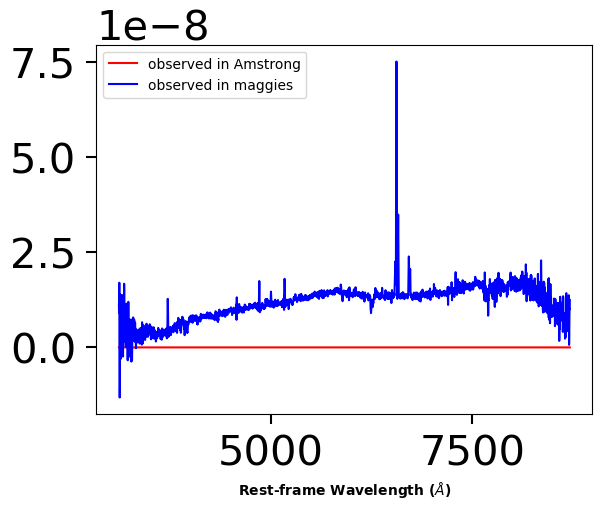

In [14]:
spec_wave, spec_fd1 = load_spec_FLM('/Users/adaezeibik/virtual_ubuntu/PS1-11aop/PS1-11aop-host-dered.flm')
#spec_fd = convert_flux2Jansky(spec_fd1*1e-15, spec_wave)
#with emission, 
spec_fdmaggie = convert_flux2Jansky(spec_fd1*1e-15,spec_wave)

plt.plot(spec_wave,spec_fd1*1e-15,color='red',label='observed in Amstrong')
plt.plot(spec_wave,(spec_fdmaggie),color='blue',label='observed in maggies')
plt.legend(fontsize=10)
#plt.xlim(3000,5000)
#plt.ylim(0.1,1e-7)
#plt.ylabel(r'maggies',fontsize=10,fontweight='bold')
plt.xlabel(r'Rest-frame Wavelength ($\AA$)',fontsize=10,fontweight='bold')


In [6]:
#Used this to re-run prospector for stellar mass estimation using modified spectra
from astropy.io import ascii
file_mod='/Users/adaezeibik/Thesis_related/PS11aop_work/paper-figures/modifiedspectraPS11aop.csv'
data_mod = ascii.read(file_mod,format='csv')
lambd = data_mod['waveAng'] 
#fluxmag = data_mod['fluxmaggies']
fluxmag = data_mod['fluxmaggies_adj'] #subtracted spectra

In [7]:
def build_obs(snr=3, ldist=10, **extras):
    """Build a dictionary of observational data.  In this example 
    the data consist of photometry for a single nearby dwarf galaxy 
    from Johnson et al. 2013.
    
    :param snr:
        The S/N to assign to the photometry, since none are reported 
        in Johnson et al. 2013
        
    :param ldist:
        The luminosity distance to assume for translating absolute magnitudes 
        into apparent magnitudes.
        
    :returns obs:
        A dictionary of observational data to use in the fit.
    """
    from prospect.utils.obsutils import fix_obs
    import sedpy

    # The obs dictionary, empty for now
    obs = {}

    # These are the names of the relevant filters, 
    # in the same order as the photometric data (see below)
    
    ps1 = ['PS1-'+n for n in 'grizy']
    sdss = ['sdss_{0}0'.format(b) for b in ['u','g','r','i','z']]
    #wise = ['wise_w'+n for n in ['1','2']] #,'3']]
    #ukir = ['ukirt_wfcam_J','ukirt_wfcam_H','ukirt_wfcam_K']
    
    filternames = ps1 + sdss #+ wise #+ ukir
     #corrected for extinction
    M_AB = np.array([19.8756,19.2340,18.8092,18.4781,18.4117,20.89300651, 19.74500651, 18.90500651,18.47200651, 18.24000651])#,18.26428691, 18.58704174])#,15.589,15.274,11.457,17.529,16.911,16.233])
    M_AB_unc = np.array([0.0572,0.024,0.0177,0.0550,0.0653,0.110,0.022,0.015,0.015,0.042])#,0.056,0.135])#,,0.217,0.033,0.028,0.031])
    #uncorrected version
   # M_AB = np.array([19.8756,19.2340,18.8092,18.4781,18.4117,21.066,19.918,19.078,18.645,18.413,15.589,15.274])#,15.589,15.274,11.457,17.529,16.911,16.233])
   # M_AB_unc = np.array([0.0572,0.024,0.0177,0.0550,0.0653,0.110,0.022,0.015,0.015,0.042,0.056,0.135])#,,0.217,0.033,0.028,0.031])

    mags = 10**(-0.4*M_AB)
    # Find lower limits of mag uncertainty
    mag_down = [x-y for (x,y) in zip(M_AB, M_AB_unc)]
    # Convert mag uncertainties to flux uncertainties
    flux_down = [10**(-0.4*x) for x in mag_down]
    flux_uncertainty = [y-x for (x,y) in zip(mags, flux_down)]
    
    obs = {}
    
    obs["filters"] = sedpy.observate.load_filters(filternames)
    
    obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])
    obs['maggies'] = np.array(mags)
    obs['maggies_unc'] = np.array(flux_uncertainty)
    #obs["maggies_unc"] = (1./snr) * obs["maggies"]

    # Now we need a mask, which says which flux values to consider in the likelihood.
    # IMPORTANT: the mask is *True* for values that you *want* to fit, 
    # and *False* for values you want to ignore.  Here we ignore the spitzer bands.
    #obs["phot_mask"] = np.array(['spitzer' not in f.name for f in obs["filters"]])

    # This is an array of effective wavelengths for each of the filters.  
    # It is not necessary, but it can be useful for plotting so we store it here as a convenience
    obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])

    # We do not have a spectrum, so we set some required elements of the obs dictionary to None.
    # (this would be a vector of vacuum wavelengths in angstroms)
    obs["wavelength"] = None
    # (this would be the spectrum in units of maggies)
    obs["spectrum"] = None
    # (spectral uncertainties are given here)
    obs['unc'] = None
    # (again, to ignore a particular wavelength set the value of the 
    #  corresponding elemnt of the mask to *False*)
    #obs['mask'] = None
    # Mask out any NaNs or infs
    #obs['phot_mask'] = np.isfinite(np.squeeze(mags)) 
    
    # This function ensures all required keys are present in the obs dictionary,
    # adding default values if necessary
    #obs = fix_obs(obs)
    # Adding in spectrum
    #spec_wave, spec_fd1 = load_spec_FLM('/Users/adaezeibik/virtual_ubuntu/PS1-11aop/PS1-11aop-host-dered.flm')
    #spec_fd2 = convert(spec_fd1*1e-15, spec_wave, micro = True) 
    #spec_fd = (spec_fd2*1e-15*1e23)/3631
    
    #spec_fd = convert_flux2Jansky(spec_fd1*1e-15, spec_wave)
    #spec_fd_unc = convert(spec_fd_unc, spec_wave, micro = True)
    # trim the spec
    chopped = chop_wave(lambd, 3500, 8000)
    spec_wave = lambd[chopped]
    spec_fd = fluxmag[chopped]
    spec_fd_unc = (1./snr) * spec_fd #spec_fd_unc[chopped]
   

    obs["wavelength"] = spec_wave*(1+0.218) 
    obs["spectrum"] = spec_fd #*10**(0.3)
    obs['unc'] = spec_fd_unc

    return obs

In [ ]:
build_obs(snr=10, ldist=1070,)

And we will store some meta-parameters that control the input arguments to this method:

In [546]:
run_params = {}
#run_params["snr"] = 10.0
#run_params["ldist"] = 10 #269

Let's take a look at the final `obs` disctionary and also plot up our data.

Obs Dictionary Keys:

dict_keys(['filters', 'phot_wave', 'maggies', 'maggies_unc', 'wavelength', 'spectrum', 'unc'])

--------
Filter objects:

[<class 'sedpy.observate.Filter'>(PS1-g), <class 'sedpy.observate.Filter'>(PS1-r), <class 'sedpy.observate.Filter'>(PS1-i), <class 'sedpy.observate.Filter'>(PS1-z), <class 'sedpy.observate.Filter'>(PS1-y), <class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(sdss_g0), <class 'sedpy.observate.Filter'>(sdss_r0), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(sdss_z0)]


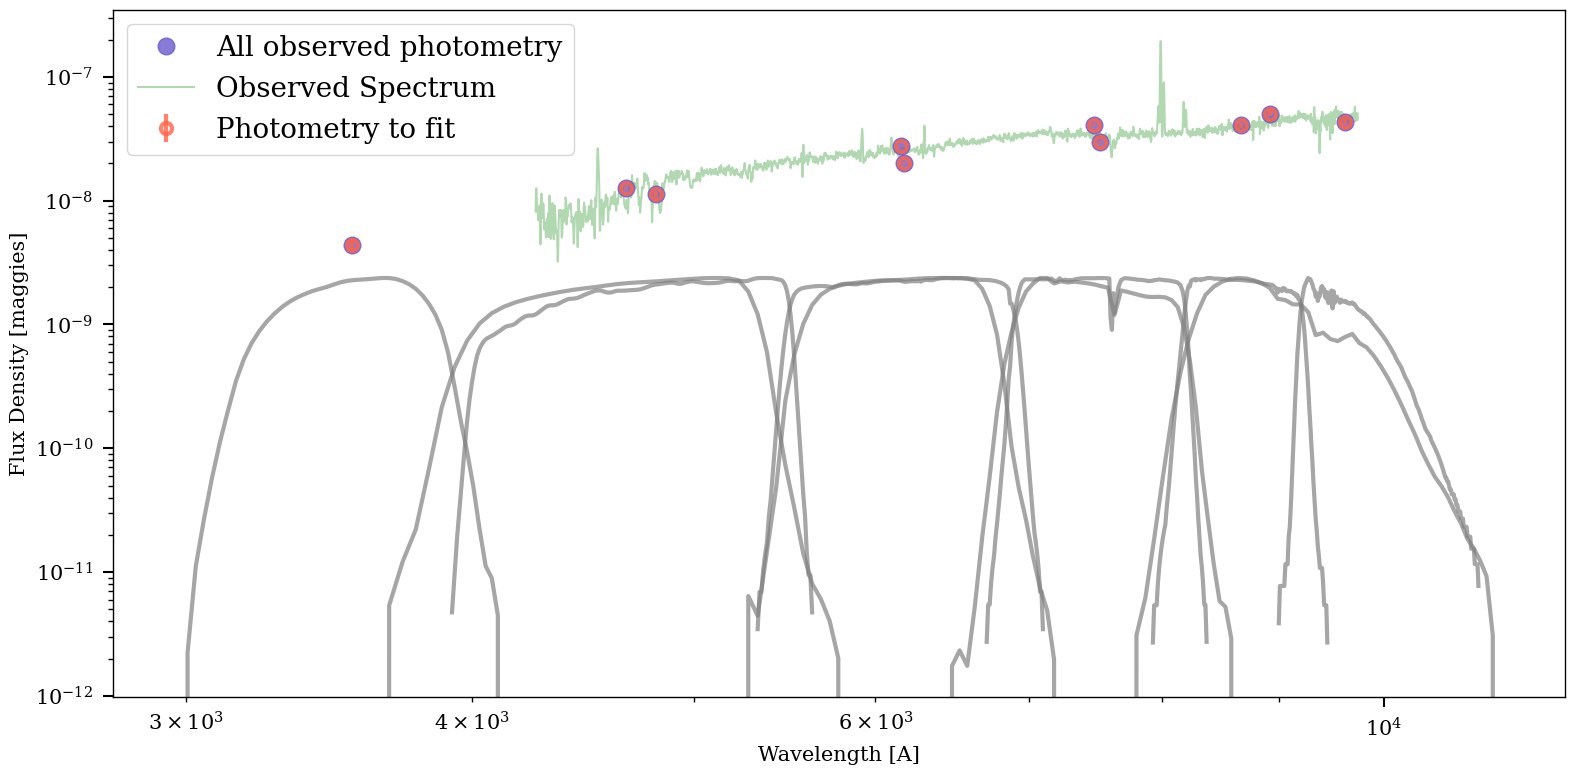

In [547]:
obs = build_obs(**run_params)
# Look at the contents of the obs dictionary
print("Obs Dictionary Keys:\n\n{}\n".format(obs.keys()))
print("--------\nFilter objects:\n")
print(obs["filters"])
    
    
# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]
obsspec = obs["spectrum"]
obserr = obs['unc'] 
obswave = obs['wavelength']

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.2, obs["maggies"].max()/0.4
figure(figsize=(16,8))

plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

# overplot only the data we intend to fit
#mask = obs["phot_mask"]
errorbar(wphot, obs['maggies'], 
         yerr=obs['maggies_unc'], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

#plot(obsspec, label='Model Spectrum', lw=0.7, color= "blueviolet",
#        alpha=0.5, zorder=1)
    # Observed Spectrum
#mask = obs['mask']
plot(obswave, obsspec, color= "green", alpha=0.3, zorder=0,
        label="Observed Spectrum")
#plot(obswave, obserr, color='k', alpha=0.6, zorder=0, label="observed spectrum error")
#plot(obswave, obsspec, obserr, color = 'gold', alpha=0.6, label="spectrum to fit")
    # Observed Spectrum Error
    
# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
#plt.xlim(2000,20000)
#plt.ylim(1e-10,0.5e-5)
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
legend(loc='best', fontsize=20)
tight_layout()
#plt.savefig('example-prospector.png',dpi = 300,transparent=True,bbox_inches='tight')

## The model object: `build_model()`

Now we need a set of model parameters, which will **define** the model we are tying to fit to the data.  The model object stores the parameters that are used by the SPS object to build a spectrum, as well as infomation about which parameters are to be varied during fitting, and priors on those parameters.  It efficiently converts between a vector of parameter values (the `theta` attribute) used by the MCMC samplers or optimizers and the dictionary of parameter names and values (the `params` attribute) that can be passed to the sps objects' `get_spectrum()` method.

To create the model object we need a list or dictionary of model parameters and some infomation about them.  Each parameter must a have a `name`, a length `N` (vector parameters are possible), an initial value `ini`, and must be specified as either a free parameter or a fixed parameter via an `isfree` key.  If it is a free parameter it *must* have a prior specified as well, which we will get from the `priors` module.  Please see the documentation for that module for detaiuls on the available priors.

Let's start by creating a dictionary that describes a single parameter controlling the stellar mass.

In [548]:
from prospect.models import priors
mass_param = {"name": "mass",
              # The mass parameter here is a scalar, so it has N=1
              "N": 1,
              # We will be fitting for the mass, so it is a free parameter
              "isfree": True,
              # This is the initial value. For fixed parameters this is the
              # value that will always be used. 
              "init": 1e8,
              # This sets the prior probability for the parameter
              "prior": priors.LogUniform(mini=1e6, maxi=1e12),
              # this sets the initial dispersion to use when generating 
              # clouds of emcee "walkers".  It is not required, but can be very helpful.
              "init_disp": 1e6, 
              # this sets the minimum dispersion to use when generating 
              #clouds of emcee "walkers".  It is not required, but can be useful if 
              # burn-in rounds leave the walker distribution too narrow for some reason.
              "disp_floor": 1e6, 
              # This is not required, but can be helpful
              "units": "solar masses formed",
              }

Ok, that's the description for one parameter.  Let's **build up the rest of our model** as a dictionary of these parameter descriptions, keyed by parameter name.  The type of model you build will depend on your data, the type of object you are looking at,  and your scientific question. For this data, at a minimum we will need some sort of distance or redshift information (which in this example is a fixed parameter), and something descibing the SFH.  We could also add parameters controlling metallicity, dust attenuation and emission, nebular emission, even the IMF. Note that any parameter whose value is not explicitly specified via a model parameter dictionary will be given the default value from python-FSPS.

While we could keep adding parameters by hand, the easiest way to build up this model is to start with some predefined parameter sets from the `prospect.models.templates` module, and then modify them to suit our needs. First, lets look at what pre-packaged parameter sets are available.

In [549]:
from prospect.models.templates import TemplateLibrary

# Look at all the prepackaged parameter sets
TemplateLibrary.show_contents()

'type_defaults':
  Explicitly sets dust amd IMF types.
'ssp':
  Basic set of (free) parameters for a delta function SFH
'parametric_sfh':
  Basic set of (free) parameters for a delay-tau SFH.
'dust_emission':
  The set of (fixed) dust emission parameters.
'nebular':
  The set of nebular emission parameters, with gas_logz tied to stellar logzsol.
'nebular_marginalization':
  Marginalize over emission amplitudes line contained inthe observed spectrum
'fit_eline_redshift':
  Fit for the redshift of the emission lines separatelyfrom the stellar redshift
'agn_eline':
  Add AGN emission lines
'outlier_model':
  The set of outlier (mixture) models for spectroscopy and photometry
'agn':
  The set of (fixed) AGN dusty torus emission parameters.
'igm':
  The set of (fixed) IGM absorption parameters.
'spectral_smoothing':
  Set of parameters for spectal smoothing.
'optimize_speccal':
  Set of parameters (most of which are fixed) for optimizing a polynomial calibration vector.
'fit_speccal':
  Set

It looks like the `"parametric_sfh"` parameter set will do most of what we want.  Let's look at it in more detail.

In [550]:
TemplateLibrary.describe("parametric_sfh") #if you have spectroscopic data, then you can use non-parametric, also if the

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: 0.1 
  sfh: 4 
  imf_type: 2 
  dust_type: 0 


That looks pretty good, this model has 5 free parameters:
- stellar mass *formed* $M_\star$,
- metallicity $\log Z/Z_\odot$, 
- age $t$ of the galaxy 
- star formation timescale $\tau$ for an exponentially declining star formation history (SFH), and
- dust attenuation optical depth for a foreground screen, $A_V$.

Everything else here is fixed explicitly (e.g. Chabrier IMF via `imf_type:2`).  There are many other `sps` parameters that are set implicitly in the FSPS defaults.  See the python-FSPS documentation for a complete list and details on the default values.

Note that by default the stellar mass here refers to the stellar mass *formed* by the given age, which will always be slightly higher than the *surviving* stellar mass, due to mass loss during stellar evolution (winds, SNe, etc.)

To tailor this model to our data we'll want to just adjust a couple of the initial values and priors, and add a parameter that will set the distance even though the redshift of theses objects is zero (remember we used absolute magnitudes - these particular very nearby objects are decoupled from the Hubble flow and have very small redshifts, or even blueshifts).

However, as for the ``obs`` dictionary we will do all this model building inside a method called ``build_model``.
This is useful because then we can control (at run-time) how the model is built via more meta-parameters.  For example the redshift of the model can be specified, or we can decide to change a prior depending on which object the model is fitting. Let's do an example where we change whether the metallicity is a free parameter of the fit or fixed to a particular value, optionally turn on dust emission in the model, and where we can set the redshift by hand as well.

In [551]:
def dust2_to_dust1(dust2=None, **kwargs):
    return dust2
def gas_logz(gas_logz=None, **kwargs):
    return gas_logz
def massmet_to_mass(massmet=None, **extras):
    return 10**massmet[0]
def massmet_to_logzol(massmet=None,**extras):
    return massmet[1]

In [552]:
#model with emission lines turned off
def build_model(object_redshift=0.218, ldist=1070,opt_spec=True, fixed_metallicity=None, add_duste=False, 
                **extras):
    """Build a prospect.models.SedModel object
    
    :param object_redshift: (optional, default: None)
        If given, produce spectra and observed frame photometry appropriate 
        for this redshift. Otherwise, the redshift will be zero.
        
    :param ldist: (optional, default: 10)
        The luminosity distance (in Mpc) for the model.  Spectra and observed 
        frame (apparent) photometry will be appropriate for this luminosity distance.
        
    :param fixed_metallicity: (optional, default: None)
        If given, fix the model metallicity (:math:`log(Z/Z_sun)`) to the given value.
        
    :param add_duste: (optional, default: False)
        If `True`, add dust emission and associated (fixed) parameters to the model.
        
    :returns model:
        An instance of prospect.models.SedModel
    """
    from prospect.models.sedmodel import SedModel
    from prospect.models.sedmodel import PolySedModel
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors

    # Get (a copy of) one of the prepackaged model set dictionaries.
    # This is, somewhat confusingly, a dictionary of dictionaries, keyed by parameter name
    model_params = TemplateLibrary["parametric_sfh"]
    
   # Now add the lumdist parameter by hand as another entry in the dictionary.
   # This will control the distance since we are setting the redshift to zero.  
   # In `build_obs` above we used a distance of 10Mpc to convert from absolute to apparent magnitudes, 
   # so we use that here too, since the `maggies` are appropriate for that distance.
   
    #lumdist
    #model_params["lumdist"] = {"N": 1, "isfree": False, "init": ldist, "units":"Mpc"}
    
    # Let's make some changes to initial values appropriate for our objects and data
    model_params["zred"]["init"] = 0.218
    model_params["dust2"]["init"] = 0.1
    model_params["logzsol"]["init"] = 1.0
    model_params["tage"]["init"] = 9.
    model_params["mass"]["init"] = 5e10
    model_params["tau"]["init"] = 2
    #sfr_avg(times=None, dt=0.1)
    
    # the tau parameter upward, and the mass prior downward
    model_params["dust2"]["prior"] = priors.TopHat(mini=0.3, maxi=0.66)
    model_params["tau"]["prior"] = priors.LogUniform(mini=0.05, maxi=4.0)
    model_params["mass"]["prior"] = priors.LogUniform(mini=1e10, maxi=1e11)
    model_params["logzsol"]["prior"] = priors.TopHat(mini= -2.2, maxi= 0)
    model_params["tage"]["prior"] = priors.LogUniform(mini=4, maxi=8.5)
    #model_params["tage"]["prior"] = priors.LogUniform(mini=0.5, maxi=2.5)     

    # If we are going to be using emcee, it is useful to provide a 
    # minimum scale for the cloud of walkers (the default is 0.1)
    model_params["mass"]["disp_floor"] = 1e6
    model_params["tau"]["disp_floor"] = 1.0
    model_params["tage"]["disp_floor"] = 1.0
    
    # Change the model parameter specifications based on some keyword arguments
    #if fixed_metallicity is not None:
        # make it a fixed parameter
     #   model_params["logzsol"]["isfree"] = True
        #And use value supplied by fixed_metallicity keyword
        #model_params["logzsol"]['init'] = fixed_metallicity 
    #if add_nebular:
     #   model_params.update(TemplateLibrary["nebular"])
     #   model_params["nebemlineinspec"]["init"] = True
      #  #added because spectrum is available 
        #model_params['gas_logu']['isfree'] = True
        #model_params['gas_logz']['isfree'] = True
        #model_params['gas_logz']['depends_on'] = gas_logz 
        
    if object_redshift is not None:
        # make sure zred is fixed
        model_params["zred"]['isfree'] = False
        # And set the value to the object_redshift keyword
        model_params["zred"]['init'] = object_redshift

    if add_duste:
        
        # Add dust emission (with fixed dust SED parameters)
        # Since `model_params` is a dictionary of parameter specifications, 
        # and `TemplateLibrary` returns dictionaries of parameter specifications, 
        # we can just update `model_params` with the parameters described in the 
        # pre-packaged `dust_emission` parameter set.
        model_params.update(TemplateLibrary["dust_emission"])
        
    if opt_spec:
        model_params.update(TemplateLibrary['optimize_speccal'])
        # Fit for normalization of spectrum
        model_params['spec_norm'] = {'N': 1, 'init': 1.0, 'isfree': False, 'prior':
                                    priors.Normal(sigma=0.2, mean=1.0), 'units': 'f_true/f_obs'}
        
        # Increase the polynomial size to 12
        model_params['polyorder'] = {'N': 1, 'init': 10, 'isfree': False}
        
        run_params['opt_spec'] = True    
        # Now instantiate the model object using this dictionary of parameter specifications
        model = PolySedModel(model_params)
        
    elif opt_spec == False:
        model = SedModel(model_params)
        run_params['opt_spec'] = False   
        
    # Now instantiate the model object using this dictionary of parameter specifications
    model = SedModel(model_params)

    return model



run_params["object_redshift"] = 0.218
run_params["fixed_metallicity"] = None
run_params["add_duste"] = True

In [500]:
#model with emission lines turned on
def build_model(object_redshift=0.218, ldist=1070,opt_spec=True, fixed_metallicity=None,add_nebular=True, add_duste=False, 
                **extras):
    """Build a prospect.models.SedModel object
    
    :param object_redshift: (optional, default: None)
        If given, produce spectra and observed frame photometry appropriate 
        for this redshift. Otherwise, the redshift will be zero.
        
    :param ldist: (optional, default: 10)
        The luminosity distance (in Mpc) for the model.  Spectra and observed 
        frame (apparent) photometry will be appropriate for this luminosity distance.
        
    :param fixed_metallicity: (optional, default: None)
        If given, fix the model metallicity (:math:`log(Z/Z_sun)`) to the given value.
        
    :param add_duste: (optional, default: False)
        If `True`, add dust emission and associated (fixed) parameters to the model.
        
    :returns model:
        An instance of prospect.models.SedModel
    """
    from prospect.models.sedmodel import SedModel
    from prospect.models.sedmodel import PolySedModel
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors

    # Get (a copy of) one of the prepackaged model set dictionaries.
    # This is, somewhat confusingly, a dictionary of dictionaries, keyed by parameter name
    model_params = TemplateLibrary["parametric_sfh"]
    
   # Now add the lumdist parameter by hand as another entry in the dictionary.
   # This will control the distance since we are setting the redshift to zero.  
   # In `build_obs` above we used a distance of 10Mpc to convert from absolute to apparent magnitudes, 
   # so we use that here too, since the `maggies` are appropriate for that distance.
   
    #lumdist
    #model_params["lumdist"] = {"N": 1, "isfree": False, "init": ldist, "units":"Mpc"}
    
    # Let's make some changes to initial values appropriate for our objects and data
    model_params["zred"]["init"] = 0.218
    model_params["dust2"]["init"] = 0.1
    model_params["logzsol"]["init"] = 1.0
    model_params["tage"]["init"] = 9.
    model_params["mass"]["init"] = 5e10
    model_params["tau"]["init"] = 2
    #sfr_avg(times=None, dt=0.1)
    
    # the tau parameter upward, and the mass prior downward
    model_params["dust2"]["prior"] = priors.TopHat(mini=0.3, maxi=0.66)
    model_params["tau"]["prior"] = priors.LogUniform(mini=0.05, maxi=4.0)
    model_params["mass"]["prior"] = priors.LogUniform(mini=1e10, maxi=1e11)
    model_params["logzsol"]["prior"] = priors.TopHat(mini= -2.2, maxi= 0)
    model_params["tage"]["prior"] = priors.LogUniform(mini=4, maxi=8.5)
    #model_params["tage"]["prior"] = priors.LogUniform(mini=0.5, maxi=2.5)     

    # If we are going to be using emcee, it is useful to provide a 
    # minimum scale for the cloud of walkers (the default is 0.1)
    model_params["mass"]["disp_floor"] = 1e6
    model_params["tau"]["disp_floor"] = 1.0
    model_params["tage"]["disp_floor"] = 6.0
    
    # Change the model parameter specifications based on some keyword arguments
    #if fixed_metallicity is not None:
        # make it a fixed parameter
     #   model_params["logzsol"]["isfree"] = True
        #And use value supplied by fixed_metallicity keyword
        #model_params["logzsol"]['init'] = fixed_metallicity 
    if add_nebular:
        model_params.update(TemplateLibrary["nebular"])
        model_params["nebemlineinspec"]["init"] = True
        #added because spectrum is available 
        #model_params['gas_logu']['isfree'] = True
        #model_params['gas_logz']['isfree'] = True
        #model_params['gas_logz']['depends_on'] = gas_logz 
        
    if object_redshift is not None:
        # make sure zred is fixed
        model_params["zred"]['isfree'] = False
        # And set the value to the object_redshift keyword
        model_params["zred"]['init'] = object_redshift

    if add_duste:
        
        # Add dust emission (with fixed dust SED parameters)
        # Since `model_params` is a dictionary of parameter specifications, 
        # and `TemplateLibrary` returns dictionaries of parameter specifications, 
        # we can just update `model_params` with the parameters described in the 
        # pre-packaged `dust_emission` parameter set.
        model_params.update(TemplateLibrary["dust_emission"])
        
    if opt_spec:
        model_params.update(TemplateLibrary['optimize_speccal'])
        # Fit for normalization of spectrum
        model_params['spec_norm'] = {'N': 1, 'init': 1.0, 'isfree': False, 'prior':
                                    priors.Normal(sigma=0.2, mean=1.0), 'units': 'f_true/f_obs'}
        
        # Increase the polynomial size to 12
        model_params['polyorder'] = {'N': 1, 'init': 10, 'isfree': False}
        
        run_params['opt_spec'] = True    
        # Now instantiate the model object using this dictionary of parameter specifications
        model = PolySedModel(model_params)
        
    elif opt_spec == False:
        model = SedModel(model_params)
        run_params['opt_spec'] = False   
        
    # Now instantiate the model object using this dictionary of parameter specifications
    model = SedModel(model_params)

    return model


run_params["object_redshift"] = 0.218
run_params["fixed_metallicity"] = None
run_params["add_duste"] = True

Now let's build the model using this function and take a look at it:

In [553]:
model = build_model(**run_params)
print(model)
print("\nInitial free parameter vector theta:\n  {}\n".format(model.theta))
print("Initial parameter dictionary:\n{}".format(model.params))

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=10000000000.0,maxi=100000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2.2,maxi=0)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.3,maxi=0.66)
  tage: <class 'prospect.models.priors.LogUniform'>(mini=4,maxi=8.5)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.05,maxi=4.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.218] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [0] 
  add_dust_emission: [ True] 
  duste_umin: [1.] 
  duste_qpah: [4.] 
  duste_gamma: [0.001] 
  polyorder: [10] 
  poly_regularization: [0.] 
  spec_norm: [1.] 

Initial free parameter vector theta:
  [5.e+10 1.e+00 1.e-01 9.e+00 2.e+00]

Initial parameter dictionary:
{'zred': array([0.218]), 'mass': array([5.e+10]), 'logzsol': array([1.]), 'dust2': array([0.1]), 'sfh': array([4]), 'tage': array([9.]), 'i

## The source object: `build_sps()`

We are almost there, but we need an object that will build SEDs for a given set of parameters.  In *prospector* we call these *sps* objects.  Given a dictionary of parameters (provided by the model object), they must be able to return a spectrum and photometry -- corresponding to the data in the `obs` dictionary -- and maybe some ancillary information.  The generation of spectra and photometry is often done using large spectral libraries and, for galaxies, isochrone information.  Typically in *prospector* we use `fsps.StellarPopulation` objects, under thin wrappers that add a little functionality and change the API a bit. The different wrappers correspond to different SFH parameterizations. Here we use `CSPSpecBasis` which works with (linear combinations of) composite stellar populations,  as described in the FSPS manual with `sfh_type` of 1, 4, or 5.  Other `sps` objects can be used for non-parameteric SFH, notably `prospect.sources.FastStepBasis`.

Again, it can be helpful to encapsulate the loading of the sps object in a `load_sps` method, with meta-parameters controlling the how the object is instantiated

In [554]:
def build_sps(zcontinuous=1, **extras):
    """
    :param zcontinuous: 
        A vlue of 1 insures that we use interpolation between SSPs to 
        have a continuous metallicity parameter (`logzsol`)
        See python-FSPS documentation for details
    """
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous)
    return sps

run_params["zcontinuous"] = 1

This object often has a large memory footprint, since it contains all the spectral libraries and isochrones.
It has one very important method, `get_spectrum()`.  Indeed, the only definition of an `sps` object (for example if you want to make your own) is that it have this method.  In typical use, any FSPS parameter can be passed to this method as an extra keyword argument and the model will be built using that parameter.  Several additional parameters controlling, e.g., spectral smoothing or the wavelength calibration can also be passed to the default objects.

In [555]:
sps = build_sps(**run_params)
help(sps.get_spectrum)

Help on method get_spectrum in module prospect.sources.ssp_basis:

get_spectrum(outwave=None, filters=None, peraa=False, **params) method of prospect.sources.galaxy_basis.CSPSpecBasis instance
    Get a spectrum and SED for the given params.
    
    :param outwave: (default: None)
        Desired *vacuum* wavelengths.  Defaults to the values in
        ``sps.wavelength``.
    
    :param peraa: (default: False)
        If `True`, return the spectrum in erg/s/cm^2/AA instead of AB
        maggies.
    
    :param filters: (default: None)
        A list of filter objects for which you'd like photometry to be calculated.
    
    :param params:
        Optional keywords giving parameter values that will be used to
        generate the predicted spectrum.
    
    :returns spec:
        Observed frame spectrum in AB maggies, unless ``peraa=True`` in which
        case the units are erg/s/cm^2/AA.
    
    :returns phot:
        Observed frame photometry in AB maggies.
    
    :returns ma

## View the model
Now that we have the `sps` object we can also generate a prediction for the data from any set of model parameters.  To see how this works, lets make an SED and plot it!  This will use the initial parameter values for the model we built before.

Note that creating a new model with FSPS is somewhat time-intensive (of order seconds), but once the relevant SSPs have been built they are subsequently stored in cache so similar models can be generated much more quickly (of order milliseconds, unless you are changing parameters that affect the SSPs, like the IMF)

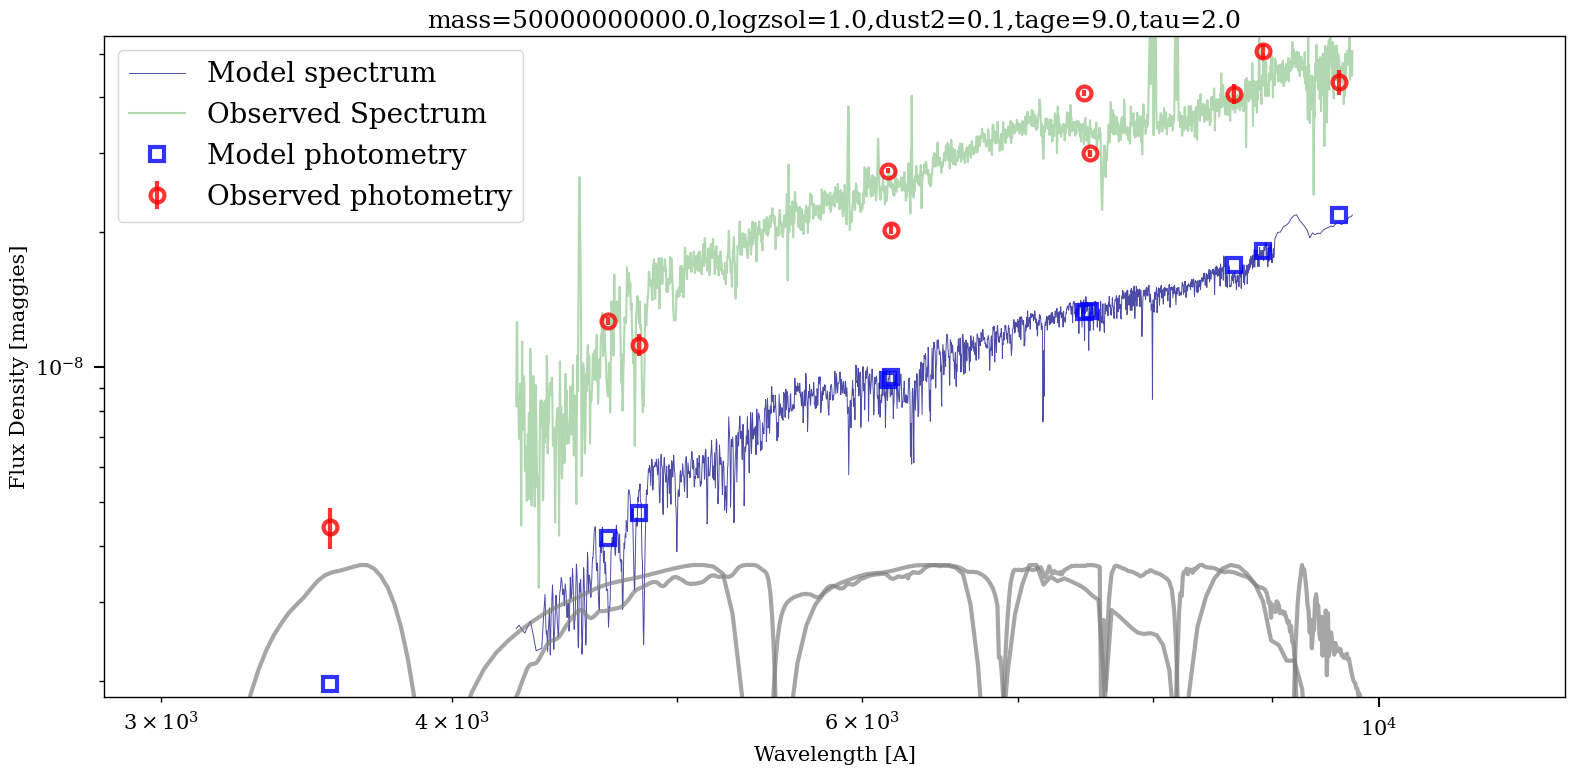

In [556]:
# Generate the model SED at the initial value of theta
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
figure(figsize=(16,8))

# plot model + data
loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
#observed spectrum
plot(obswave, obsspec, color= "green", alpha=0.3, zorder=0,
        label="Observed Spectrum")
title(title_text)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()


In [557]:
model.sed(theta, obs=obs, sps=sps)


(array([2.61299823e-09, 2.62037756e-09, 2.62775689e-09, ...,
        2.17653567e-08, 2.17994020e-08, 2.18334473e-08]),
 array([4.73687524e-09, 9.48310540e-09, 1.33688487e-08, 1.69082775e-08,
        2.18303204e-08, 1.96827530e-09, 4.16493833e-09, 9.35105117e-09,
        1.32673517e-08, 1.81640712e-08]),
 0.6396510493203483)

## Likelihood function
Now all we are missing is a likelihood function.  In most cases, this will simply be a function of the **spectral likelihood** and a **photometric likelihood** such that

$$
\mathcal{L} = f(\mathcal{L}_{\textrm{spec}}, \mathcal{L}_{\textrm{phot}}) \quad .
$$

Assuming our errors are Normal (i.e. Gaussian), the log-likelihoods for each component are extremely straightforward to define and can be imported directly from *prospector*.  How we choose to combine these likelihoods might vary depending on the particulars of our data. For the demo, our likelihood function for our model parameters $\boldsymbol{\theta}$ is just

$$
\ln\mathcal{L}(\boldsymbol{\theta}) = \ln\mathcal{L}_{\textrm{spec}}(\boldsymbol{\theta}) + \ln\mathcal{L}_{\textrm{phot}}(\boldsymbol{\theta}) \quad .
$$

Below is a simple version of the likelihood function used in *prospector*.  Note that more complicated likelihoods including covariant noise and fitted noise parameters are possible, using special NoiseModel classes within *prospector*.

For nested sampling `lnprobfn(theta, nested=True)` will return the likelihood (since the prior probability is accounted for by drawing proposals from the priors), while for other types of MCMC sampling `lnprobfn(theta, nested=False)` returns the posterior probability.

In [558]:
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log

verbose = False
def lnprobfn(theta, model=None, obs=None, sps=None, 
             nested=False, verbose=verbose):
    """
    Given a parameter vector, a model, a dictionary of observational 
    data, and an sps object, return the ln of the posterior. 
    """

    # Calculate prior probability and exit if not within prior
    # Also if doing nested sampling, do not include the basic priors, 
    # since the drawing method includes the prior probability
    lnp_prior = model.prior_product(theta, nested=nested)
    if not np.isfinite(lnp_prior):
        return -np.infty
        
    # Generate "mean" model
    spec, phot, mfrac = model.mean_model(theta, obs, sps=sps)
 
    # Calculate likelihoods
    lnp_spec = lnlike_spec(spec, obs=obs)
    lnp_phot = lnlike_phot(phot, obs=obs)

    return lnp_prior + lnp_phot + lnp_spec

run_params["verbose"] = verbose



It can also be useful for some optimization methods (i.e. Levenberg-Marquardt) to define a function that returns the vector of chi-square residuals.  Let's do that.

In [559]:
from prospect.likelihood import chi_spec, chi_phot
def chivecfn(theta):
    """A version of lnprobfn that returns the simple uncertainty 
    normalized residual instead of the log-posterior, for use with 
    least-squares optimization methods like Levenburg-Marquardt.
    
    It's important to note that the returned chi vector does not 
    include the prior probability.
    """
    lnp_prior = model.prior_product(theta)
    if not np.isfinite(lnp_prior):
        return np.zeros(model.ndim) - np.infty

    # Generate mean model
    try:
        spec, phot, x = model.mean_model(theta, obs, sps=sps)
    except(ValueError):
        return np.zeros(model.ndim) - np.infty

    chispec = chi_spec(spec, obs)
    chiphot = chi_phot(phot, obs)
    return np.concatenate([chispec, chiphot])

However, *prospector* comes with a pre-built `lnprobfn` that can incorporate more complex noise models, and can be either return ln-probability or chi-square or a vector of residuals depending on the algorithm being used.  So let's use that:

In [560]:
from prospect.fitting import lnprobfn
help(lnprobfn)

Help on function lnprobfn in module prospect.fitting.fitting:

lnprobfn(theta, model=None, obs=None, sps=None, noise=(None, None), residuals=False, nested=False, negative=False, verbose=False)
    Given a parameter vector and optionally a dictionary of observational
    ata and a model object, return the matural log of the posterior. This
    requires that an sps object (and if using spectra and gaussian processes, a
    NoiseModel) be instantiated.
    
    :param theta:
        Input parameter vector, ndarray of shape (ndim,)
    
    :param model:
        SedModel model object, with attributes including ``params``, a
        dictionary of model parameter state.  It must also have
        :py:func:`prior_product`, and :py:func:`predict` methods
        defined.
    
    :param obs:
        A dictionary of observational data.  The keys should be
    
        + ``"wavelength"``  (angstroms)
        + ``"spectrum"``    (maggies)
        + ``"unc"``         (maggies)
        + ``"maggies

# Running Prospector
Now that we have defined the model and set up the data that we want to fit, we are ready to run *prospector*.  We will do this in a few steps.  First we will run all the convenience functions we made earlier to get the fitting ingredients and set up the output.  Then we will fit the model using 1) $\chi^2$ minimization; 2) ensemble MCMC sampler around the best location from the minimization 3) dynamic nested sampling with `dynesty`

In [561]:
# Here we will run all our building functions
obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)

# For fsps based sources it is useful to 
# know which stellar isochrone and spectral library
# we are using
print(sps.ssp.libraries)



(b'mist', b'miles', b'DL07  ')


We will use, appropriately enough, the `fit_model` method (with different options) for each of the three different ways of fitting the model described above.  Let's take a look at this method. 

In [562]:
from prospect.fitting import fit_model
help(fit_model)

Help on function fit_model in module prospect.fitting.fitting:

fit_model(obs, model, sps, noise=(None, None), lnprobfn=<function lnprobfn at 0x19a59edd0>, optimize=False, emcee=False, dynesty=True, **kwargs)
    Fit a model to observations using a number of different methods
    
    :param obs:
        The ``obs`` dictionary containing the data to fit to, which will be
        passed to ``lnprobfn``.
    
    :param model:
        An instance of the :py:class:`prospect.models.SedModel` class
        containing the model parameterization and parameter state.  It will be
        passed to ``lnprobfn``.
    
    :param sps:
        An instance of a :py:class:`prospect.sources.SSPBasis` (sub-)class.
        Alternatively, anything with a compatible :py:func:`get_spectrum` can
        be used here. It will be passed to ``lnprobfn``
    
    :param noise: (optional, default: (None, None))
        A tuple of NoiseModel objects for the spectroscopy and photometry
        respectively.  Can a

Note in particular that the output is a dictionary with *both* optimization and sampling entries.  This is because one can do both within a single call to `fit_model`, and for ensemble sampling in particular it can be useful to do optimization first to get close to the data before beginnning the sampling.

## Minimization
We can attempt to initialize our model reasonably close to the data by using some numerical minimization routines.
Here we will use Levenberg-Marquardt. Keywords that control the optimization algorithm will again be stored in the `run_params` dictionary. Levenberg-Marquardt requires a likelihood function that returns a vector of chi values, not an actual likelihood, but the `lnprobfn` we imported supports that.

In [520]:
# --- start minimization ----
run_params["dynesty"] = False
run_params["emcee"] = False
run_params["optimize"] = True
run_params["min_method"] = 'lm'
# We'll start minimization from "nmin" separate places, 
# the first based on the current values of each parameter and the 
# rest drawn from the prior.  Starting from these extra draws 
# can guard against local minima, or problems caused by 
# starting at the edge of a prior (e.g. dust2=0.0)
run_params["nmin"] = 2

output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)

print("Done optmization in {}s".format(output["optimization"][1]))

/Users/adaezeibik/anaconda3/envs/prospector2/lib/python3.10/site-packages/prospect/models/priors.py:120: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)


Done optmization in 214.23810195922852s


### View model after minimization
Now let's see how our model looks in the data space after minimization. The model should already be set to the result of the best optimization, but we can also find the best run and set the model parameters to that result by hand.

[ 1.30753289e+10 -1.77654576e+00  5.00000044e-01  6.19055649e+00
  1.24405392e+00]
1
[ 1.30753289e+10 -1.77654576e+00  5.00000044e-01  6.19055649e+00
  1.24405392e+00]


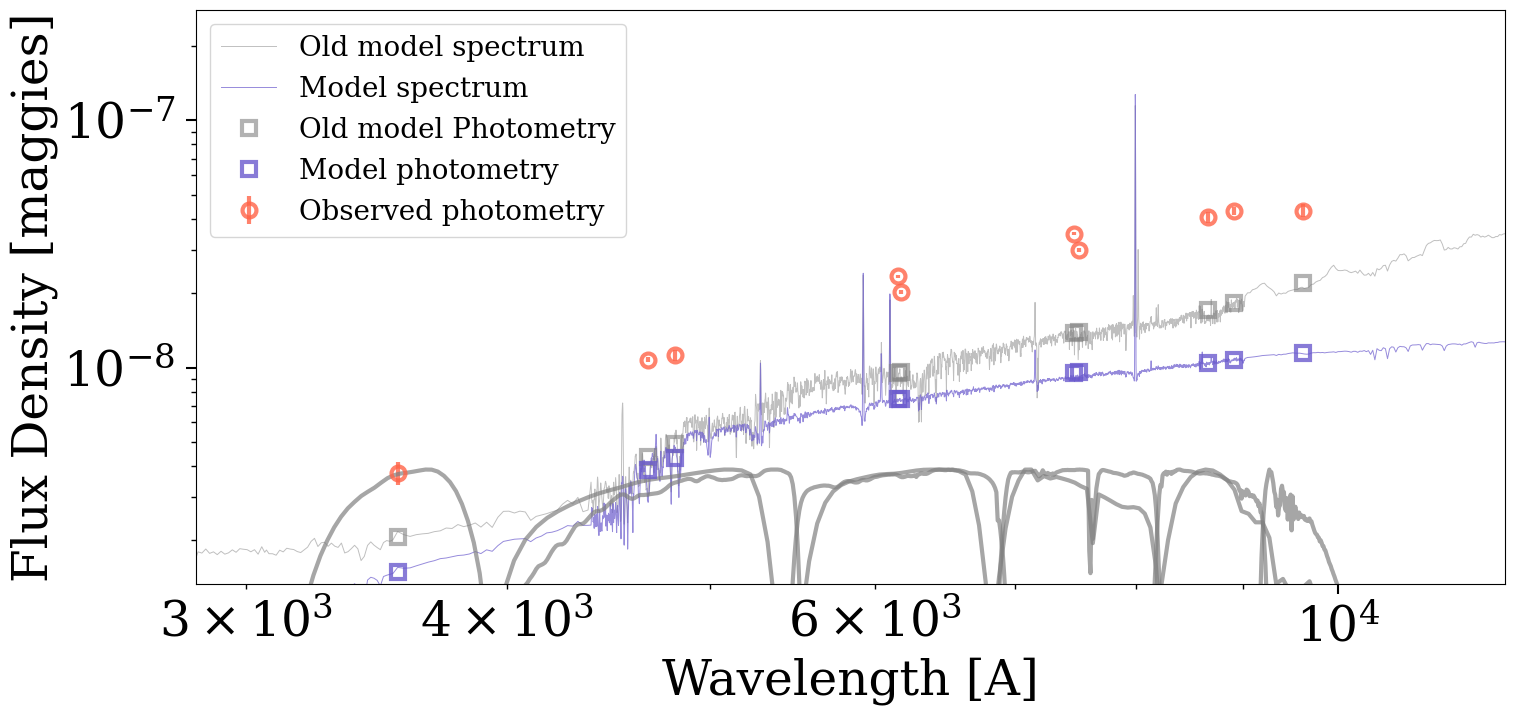

In [473]:
print(model.theta)
(results, topt) = output["optimization"]
# Find which of the minimizations gave the best result, 
# and use the parameter vector for that minimization
ind_best = np.argmin([r.cost for r in results])
print(ind_best)

theta_best = results[ind_best].x.copy()
print(theta_best)

# generate model
prediction = model.mean_model(theta_best, obs=obs, sps=sps)
pspec, pphot, pfrac = prediction

figure(figsize=(16,8))

# plot Data, best fit model, and old models
loglog(wspec, initial_spec, label='Old model spectrum',
       lw=0.7, color='gray', alpha=0.5)
errorbar(wphot, initial_phot, label='Old model Photometry', 
         marker='s', markersize=10, alpha=0.6, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='gray', 
         markeredgewidth=3)
loglog(wspec, pspec, label='Model spectrum', 
       lw=0.7, color='slateblue', alpha=0.7)
errorbar(wphot, pphot, label='Model photometry', 
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='slateblue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
         label='Observed photometry', 
         marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot filter transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

In [563]:
# dynesty Fitter run parameters
run_params = {
    'dynesty': True,
    'nlive_init': 500, # this is 'K' re:MPI
    'nested_method': 'rwalk',
    'nested_target_n_effective': 2000,
    'nested_dlogz_init': 0.05,
}



In [564]:
output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)
print('done dynesty in {0}s'.format(output["sampling"][1]))

iter: 1689 | batch: 0 | nc: 1 | ncall: 12006 | eff(%): 14.068 | logz: 50021.696 +/-  0.329 | dlogz:  0.000 >  0.050     


done dynesty (initial) in 382.4640197753906s


iter: 3844 | batch: 6 | nc: 1 | ncall: 20182 | eff(%): 16.566 | loglstar: 50029.032 < 50034.417 < 50033.413 | logz: 50021.729 +/-  0.236 | stop:  1.129     

done dynesty (dynamic) in 80.85232591629028s
done dynesty in 463.33750081062317s


In [565]:
from prospect.io import write_results as writer
#hfile = "ps11aop-photcorr-with-emission_dynesty.h5"
hfile = "modps11aop-photspec-dynestyabs1.h5"
writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])

print('Finished')

Finished


/Users/adaezeibik/anaconda3/envs/prospector2/lib/python3.10/site-packages/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/Users/adaezeibik/anaconda3/envs/prospector2/lib/python3.10/site-packages/prospect/io/write_results.py:301: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/Users/adaezeibik/anaconda3/envs/prospector2/lib/python3.10/site-packages/prospect/io/write_results.py:49: RuntimeWarning: Could not obtain prospector version info
  warnings.warn("Could not obtain prospector version info", RuntimeWarning)


In [566]:
import prospect.io.read_results as reader
results_type = "dynesty"
#result, obs, _ = reader.results_from("modps11aop-photspec-dynestyabs4.h5".format(results_type), dangerous=False)
result, obs, _ = reader.results_from("modps11aop-photspec-dynestyabs1.h5".format(results_type), dangerous=False)
print(result.keys())

dict_keys(['model_params', 'optimizer_duration', 'paramfile_text', 'prospector_version', 'run_params', 'chain', 'efficiency', 'information', 'lnlikelihood', 'lnprobability', 'logvol', 'logz', 'logzerr', 'niter', 'samples_id', 'weights', 'ncall', 'sampling_duration', 'theta_labels', 'bestfit', 'optimization', 'obs', 'model'])


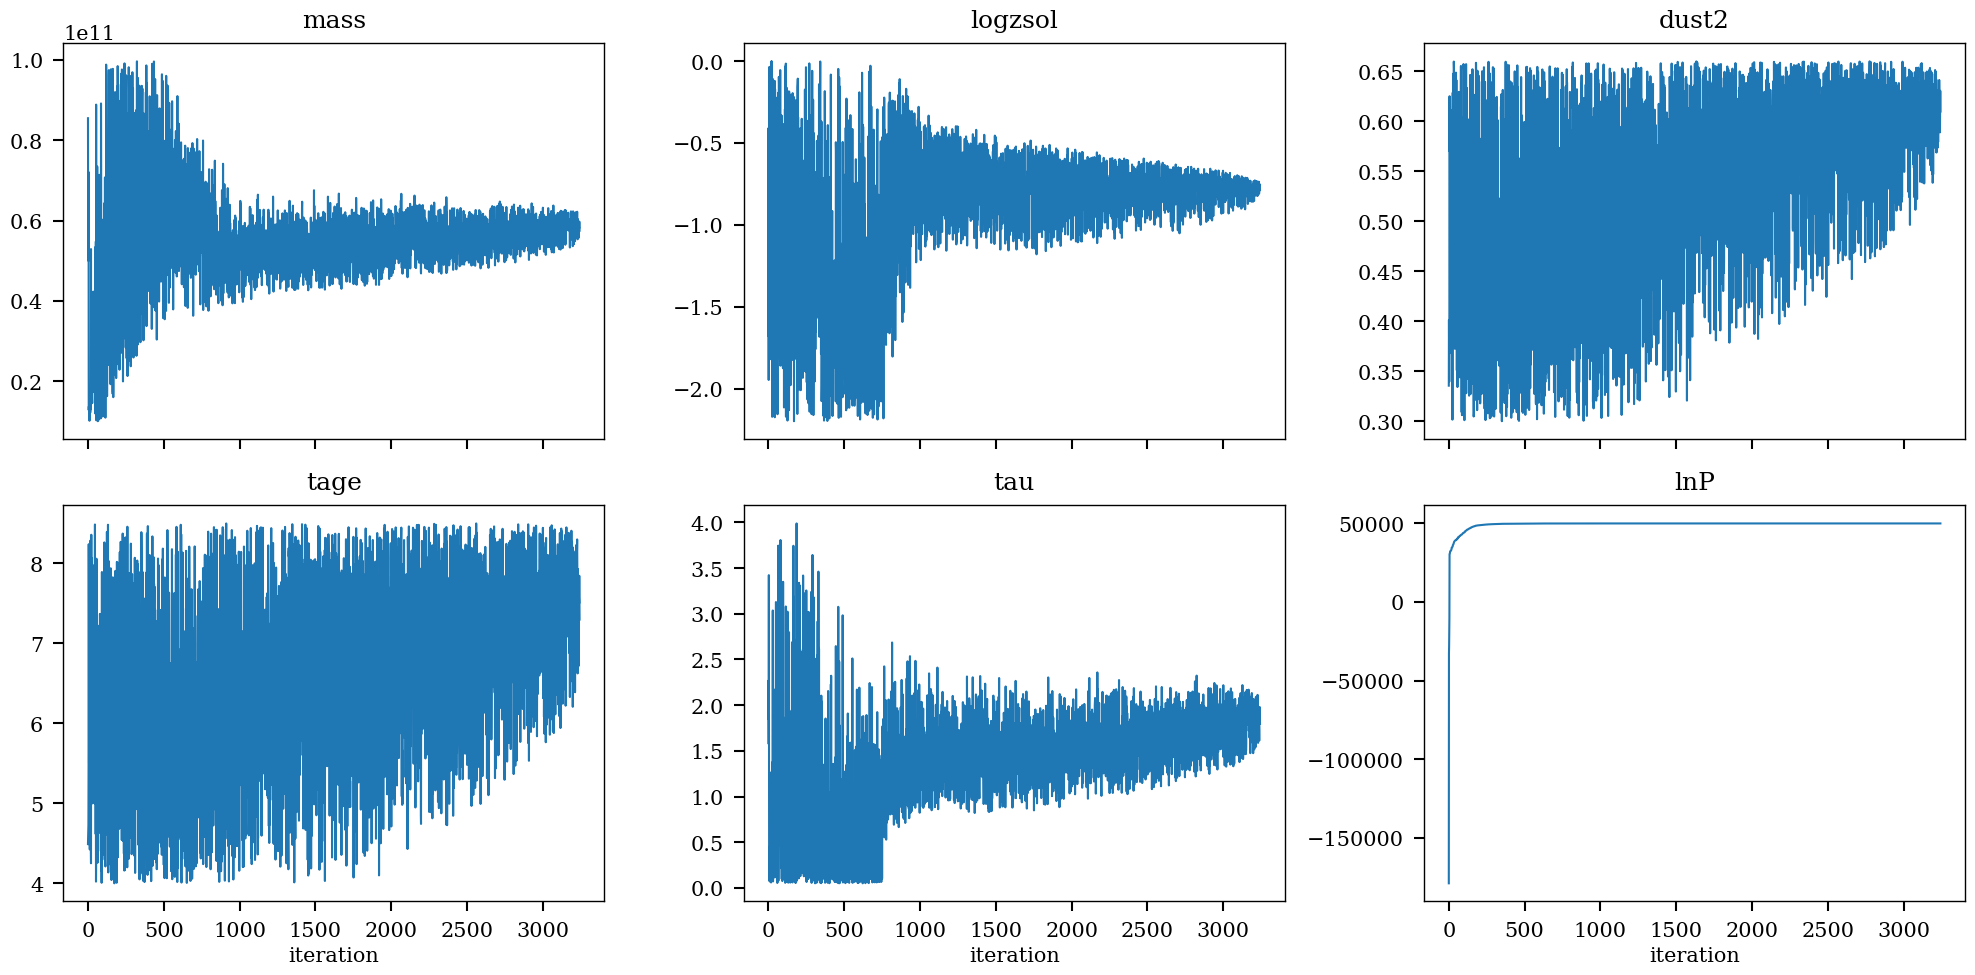

In [567]:
tracefig = reader.traceplot(result, figsize=(20,10))

<Figure size 640x480 with 0 Axes>

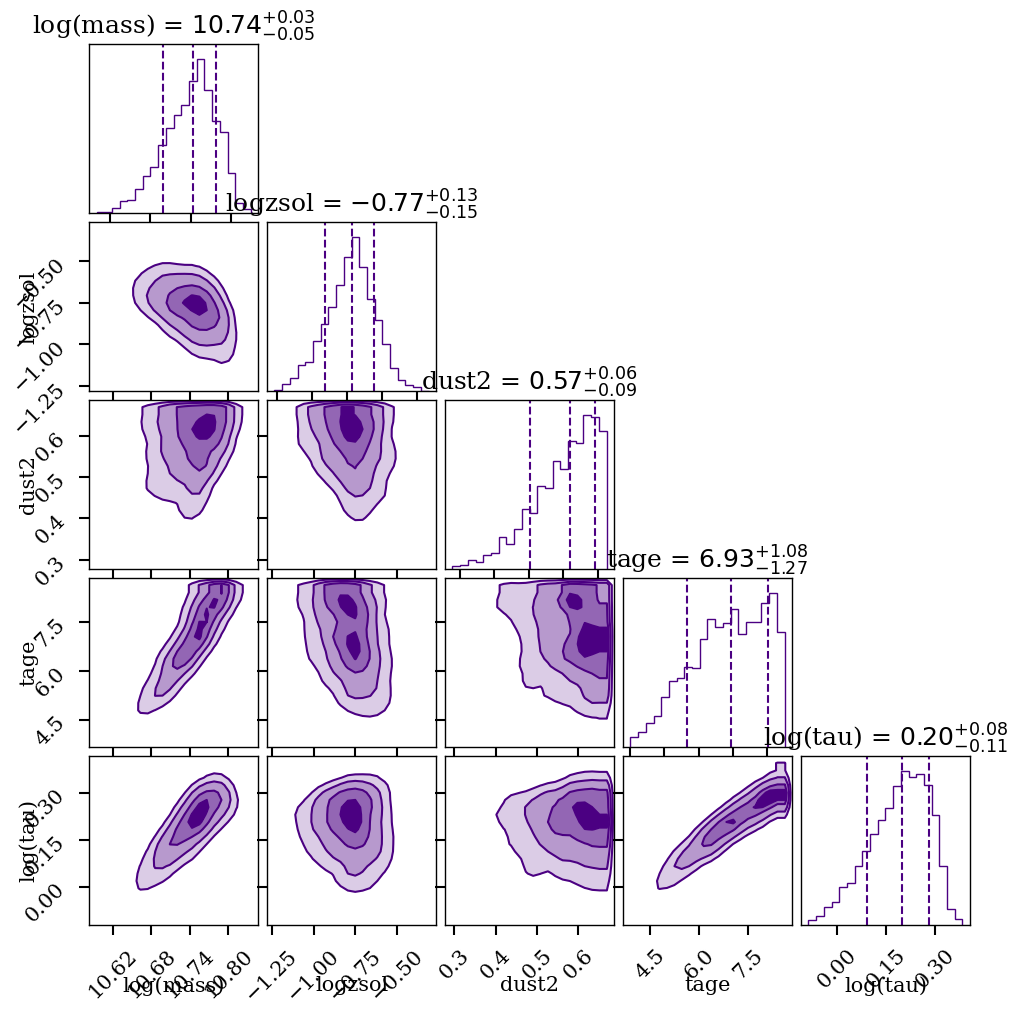

In [568]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
result, obs, model = reader.results_from("modps11aop-photspec-dynestyabs1.h5")
imax = np.argmax(result['lnprobability'])
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['axes.linewidth'] = 1
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rcParams.update({'font.size': 15})
#ax.yaxis.set_label_coords(-.1, .5)

#adjust x-axis label position 
#ax.xaxis.set_label_coords(.5, -.1)

theta_max = result['chain'][imax, :].copy()

#for ax in cornerfig.get_axes():
#    ax.tick_params(axis='both', labelsize=15, length=10, width=20, direction='in')
plt.subplots_adjust(wspace=0.1, hspace=0.05)

cornerfig = reader.subcorner(result, color = 'indigo',smooth=True,start=1000, thin=1,
                    fig=subplots(5,5,figsize=(10,10))[0], fontsize=10)
#plt.savefig('modps11aop_dynestycorr_emcorner1.png', format = 'png', dpi=300, bbox_inches="tight") #NO J BAND


In [569]:
sps = build_sps(**run_params)
model = build_model(**run_params)

flatchain = result['chain']

from prospect.utils.plotting import quantile
post_pcts = [quantile(flatchain[:, i], percents=50, weights=result.get("weights", None))
             for i in range(model.ndim)]

# These should have all the converged values
print(post_pcts)

mspec_conv, mphot_conv, _ = model.mean_model(post_pcts, obs, sps=sps)
print(mphot_conv)


[55387270014.286736, -0.77117671157086, 0.5740400261079188, 6.922564465331561, 1.5783507828215266]
[1.27839891e-08 2.48181873e-08 3.34214769e-08 3.99999543e-08
 4.58595334e-08 4.07721011e-09 1.12433732e-08 2.46048410e-08
 3.32062410e-08 4.15180789e-08]


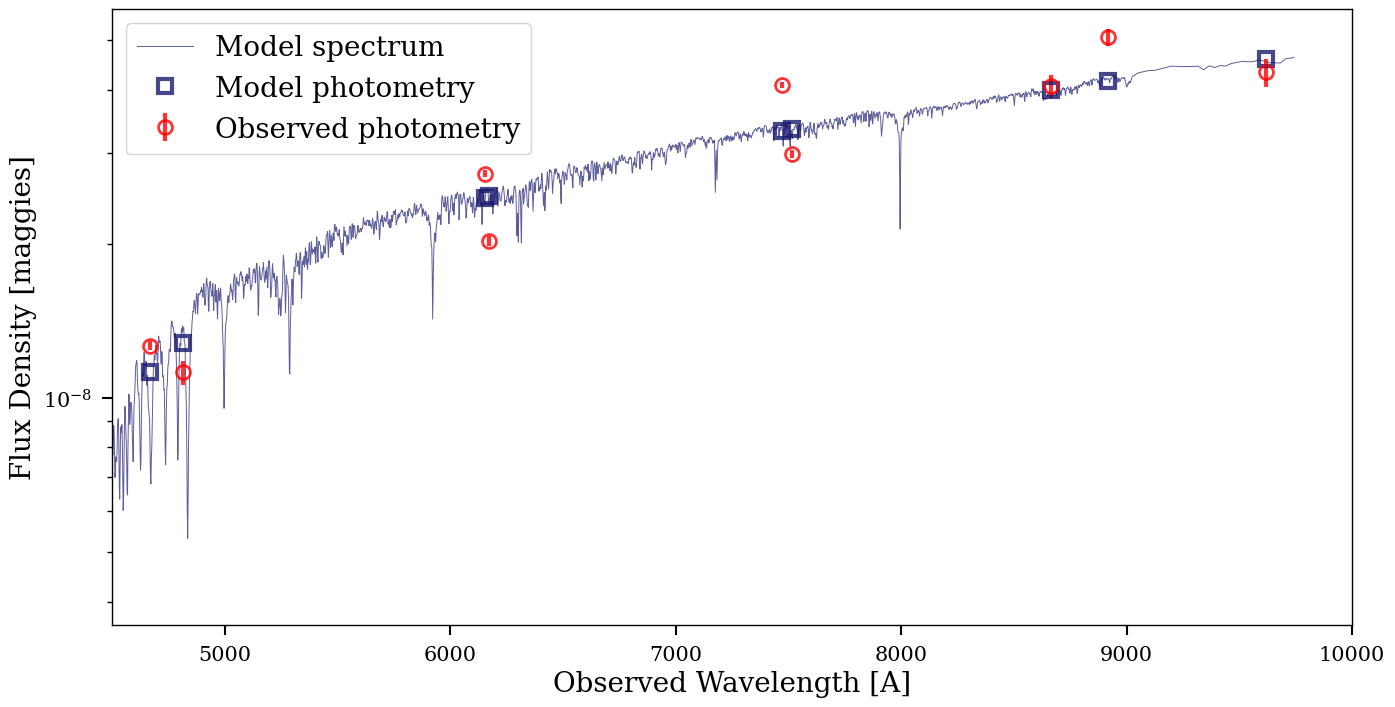

In [570]:
import matplotlib.pyplot as plt
wphot = obs["phot_wave"]

xmin, xmax = np.min(wphot)*0.7, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*6e6, obs["maggies"].max()*4e9


maggies = obs['maggies']
mags_unc = obs['maggies_unc']

# Make plot of data and model
plt.figure(figsize=(16,8))
    # Model spectrum
plt.semilogy(wspec, mspec_conv, label='Model spectrum', lw=0.7, color='midnightblue', alpha=0.7)
plt.errorbar(wphot, mphot_conv, label='Model photometry', marker='s', markersize=10, alpha=0.8, ls='', 
             lw=3,markerfacecolor='none', markeredgecolor='midnightblue', markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], label='Observed photometry', ecolor='red', marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
             markerfacecolor='none', markeredgecolor='red', markeredgewidth=2)

plt.xlabel('Observed Wavelength [A]',fontsize =20)
#plt.ylabel(r'Flux Density [$\mu$ Jy]',fontsize =20)
plt.ylabel(r'Flux Density [maggies]',fontsize =20)
#plt.title('GRB 150101B SED',fontsize =20)


xlim([xmin, xmax])
xlim([4500, 10000])
#ylim([-100, ymax])
plt.legend(loc='best', fontsize=20)
#xlim([xmin, 1e4])
#ylim([1e-9, 1e-6])
#plt.savefig('modps11aop_dynestycorr_modeled.png', format = 'png', dpi=300, bbox_inches="tight") #NO J BAND

plt.show()



In [573]:
wphot = obs['phot_wave']
obsphot = obs['maggies'] * 3631e6
obsphot_unc = obs['maggies_unc']* 3631e6
obswave = obs['wavelength']
modphot = mphot_conv * 3631e6

if run_params['opt_spec'] == True:
    mod_cal = model._speccal # Normalization factor
    norm_model_spec = (mspec_conv/mod_cal) * 3631e6
    #mask = obs['mask']
    wspec = obs['wavelength']
    obsspec = (obs['spectrum']/mod_cal) *3631e6 #Observed spectrum
    obserr = (obs['unc']/mod_cal) * 3631e6
    
# If observed spectrum was not used

elif run_params['opt_spec'] == False:
    a = 1 + model.params.get('zred')
    wsepc = sps.wavelength.copy()
    wspect *= a # redshift them
    msepc_conv *= 3631e6 # Converted model spectrum

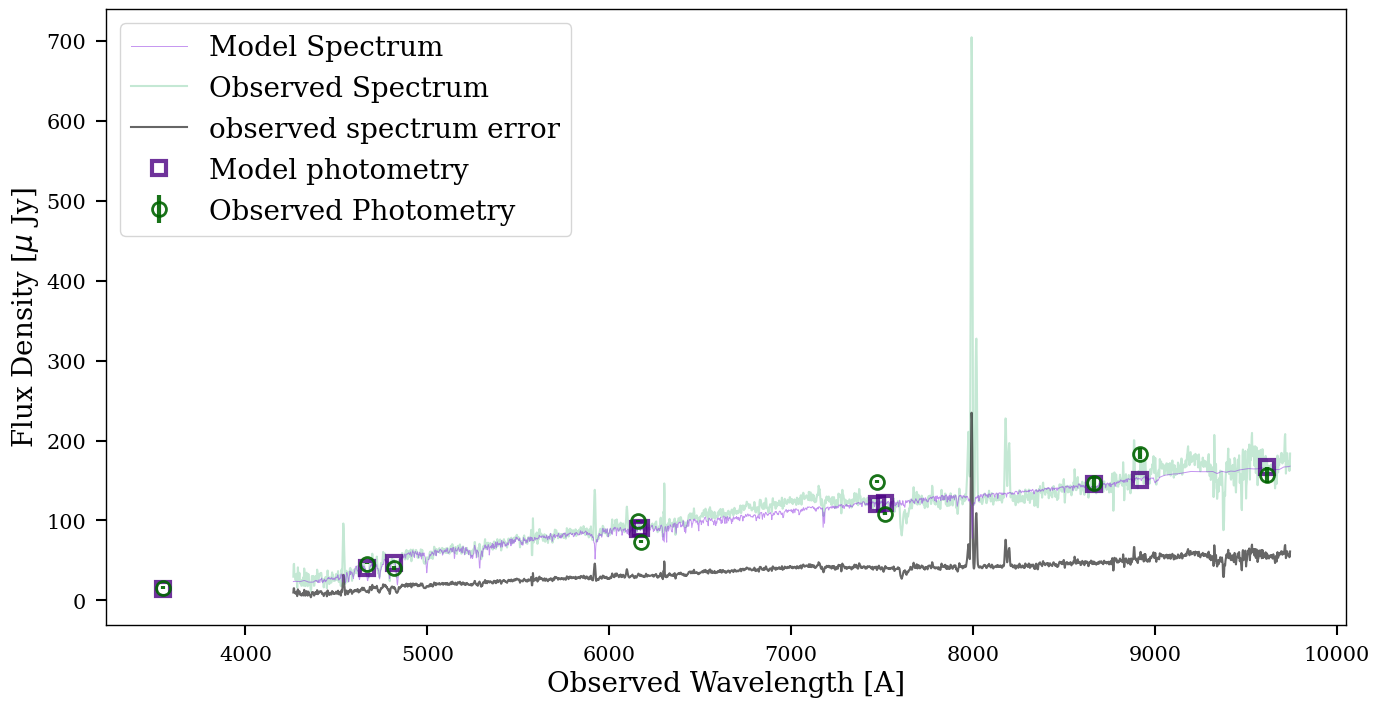

In [574]:
import matplotlib.pyplot as plt
wphot = obs["phot_wave"]

#a = 1 + 0.134

# Spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths.copy()
    #wspec *= a #redshift them
else:
    wspec = obs["wavelength"]
    
xmin, xmax = np.min(wphot)*0.7, np.max(wphot)/4
ymin, ymax = obs["maggies"].min()*6e6, obs["maggies"].max()*9e9


maggies = obs['maggies']
mags_unc = obs['maggies_unc']

# Make plot of data and model
plt.figure(figsize=(16,8))

if run_params["opt_spec"] == True:
    # Model Spectrum
    #mask = obs['mask']
    plt.plot(wspec, norm_model_spec, label='Model Spectrum', lw=0.7, color= "blueviolet",
                alpha=0.5, zorder=1)
    # Observed Spectrum
    plt.plot(obswave, obsspec, color= "mediumseagreen", alpha=0.3, zorder=0,
                label="Observed Spectrum")
    # Observed Spectrum Error
    plt.plot(obswave, obserr, color='k', alpha=0.6, zorder=0, label="observed spectrum error")
    # Observed Photometry
    plt.errorbar(wphot, modphot, label='Model photometry', marker='s', markersize=10, alpha=0.8,
                ls='', lw=3, markerfacecolor='none', markeredgecolor='indigo', markeredgewidth=3, zorder=2)
    # Observed Photometry and error
    plt.errorbar(wphot, obsphot, yerr=obsphot_unc, label = 'Observed Photometry',
                ecolor='darkgreen', marker='o', markersize=10, ls='', lw=3, alpha=0.9, 
                markerfacecolor='none', markeredgecolor='darkgreen', markeredgewidth=2, zorder=3)
elif run_params["opt_spec"] == False:
    # Model spectrum
    plt.semilogy(wspec, mspec_conv, label='Model spectrum', lw=0.7, color='midnightblue', alpha=0.7)
    plt.errorbar(wphot, mphot_conv, label='Model photometry', marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
                 markerfacecolor='none', markeredgecolor='midnightblue', markeredgewidth=3)
    plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=2)

plt.xlabel('Observed Wavelength [A]',fontsize =20)
plt.ylabel(r'Flux Density [$\mu$ Jy]',fontsize =20)



#xlim([xmin, xmax])
#xlim([0,2000])
#ylim([0, 300])
#xlim([4500, 10000])
#ylim([0, ymax])
plt.legend(loc='best', fontsize=20)
plt.savefig('modps11aop_dynestyem_photspec.png', format = 'png', dpi=300, bbox_inches="tight") #NO J BAND
plt.show()



We can also convert the tage value to a mass-weighted age. Mass-weighted ages are more robust age measurements because they don't overestimate the contribution of young, bright stars which overpopulate the SED

We use this function to convert tage and tau into a mass-weighted age:

\begin{equation}
    t_m = t_{\text{SF}} - \frac{\int_0^{t_{\text{SF}}} t \times \text{SFR}(t) dt}{ \int_0^ {t_{\text{SF}}} \text{SFR}(t) dt}.
\end{equation}

We can rewrite the corner plot code to find the distribution for mass-weighted age ($t_m$) instead of tage:

In [470]:
def age(tage, tau):
    """
    Function to convert from tage and tau to mass-weighted age
    Note that mass-weighted age = tage - age(tage, tau)
    This only works for a delayed-tau SFH
    """
    age = 2*tau - tage**2/(tau*np.exp(tage/tau)-tau-tage)
    return age

def anya_subcorner(results, showpars=None, truths=None,start=0, thin=1, chains=slice(None),
                   logify=["mass", "fagn", "tau"], **kwargs):   
    try:
        import corner as triangle
    except(ImportError):
        import triangle
    except:
        raise ImportError("Please install the `corner` package.")

    # pull out the parameter names and flatten the thinned chains
    # Get parameter names
    try:
        parnames = np.array(results['theta_labels'], dtype='U20')
    except(KeyError):
        parnames = np.array(sample_results['model'].theta_labels())
    # Restrict to desired parameters
    if showpars is not None:
        ind_show = np.array([parnames.tolist().index(p) for p in showpars])
        parnames = parnames[ind_show]
    else:
        ind_show = slice(None)

    # Get the arrays we need (trace, wghts)
    trace = results['chain'][..., ind_show]
    if trace.ndim == 2:
        trace = trace[None, :]
    trace = trace[chains, start::thin, :]
    wghts = results.get('weights', None)
    if wghts is not None:
        wghts = wghts[start::thin]
    samples = trace.reshape(trace.shape[0] * trace.shape[1], trace.shape[2])

    # logify some parameters
    xx = samples.copy()
    if truths is not None:
        xx_truth = np.array(truths).copy()
    else:
        xx_truth = None
    for p in logify:
        if p in parnames:
            idx = parnames.tolist().index(p)
            xx[:, idx] = np.log10(xx[:,idx])
            parnames[idx] = "log({})".format(parnames[idx])
            if truths is not None:
                xx_truth[idx] = np.log10(xx_truth[idx])

    # mess with corner defaults
    corner_kwargs = {"plot_datapoints": False, "plot_density": True,
                     "fill_contours": True, "show_titles": True}
    corner_kwargs.update(kwargs)
    
    # Change from optical depth to dust: note must have dust2 as free parameter for this to work
    xx[:, parnames.tolist().index('dust2')] = xx[:, parnames.tolist().index('dust2')]*1.086
    
    # Get tau value
    tau = 10**xx[:, parnames.tolist().index('log(tau)')]
    
    # Get tage value
    t_age = xx[:, parnames.tolist().index('tage')]
    
    # Convert from tage to mass-weighted age
    xx[:, parnames.tolist().index('tage')] = t_age - age(t_age,tau)
   
    fig = triangle.corner(xx, truths=xx_truth, quantiles=[0.16, 0.5, 0.84], weights=wghts, 
                          **corner_kwargs)

    return fig

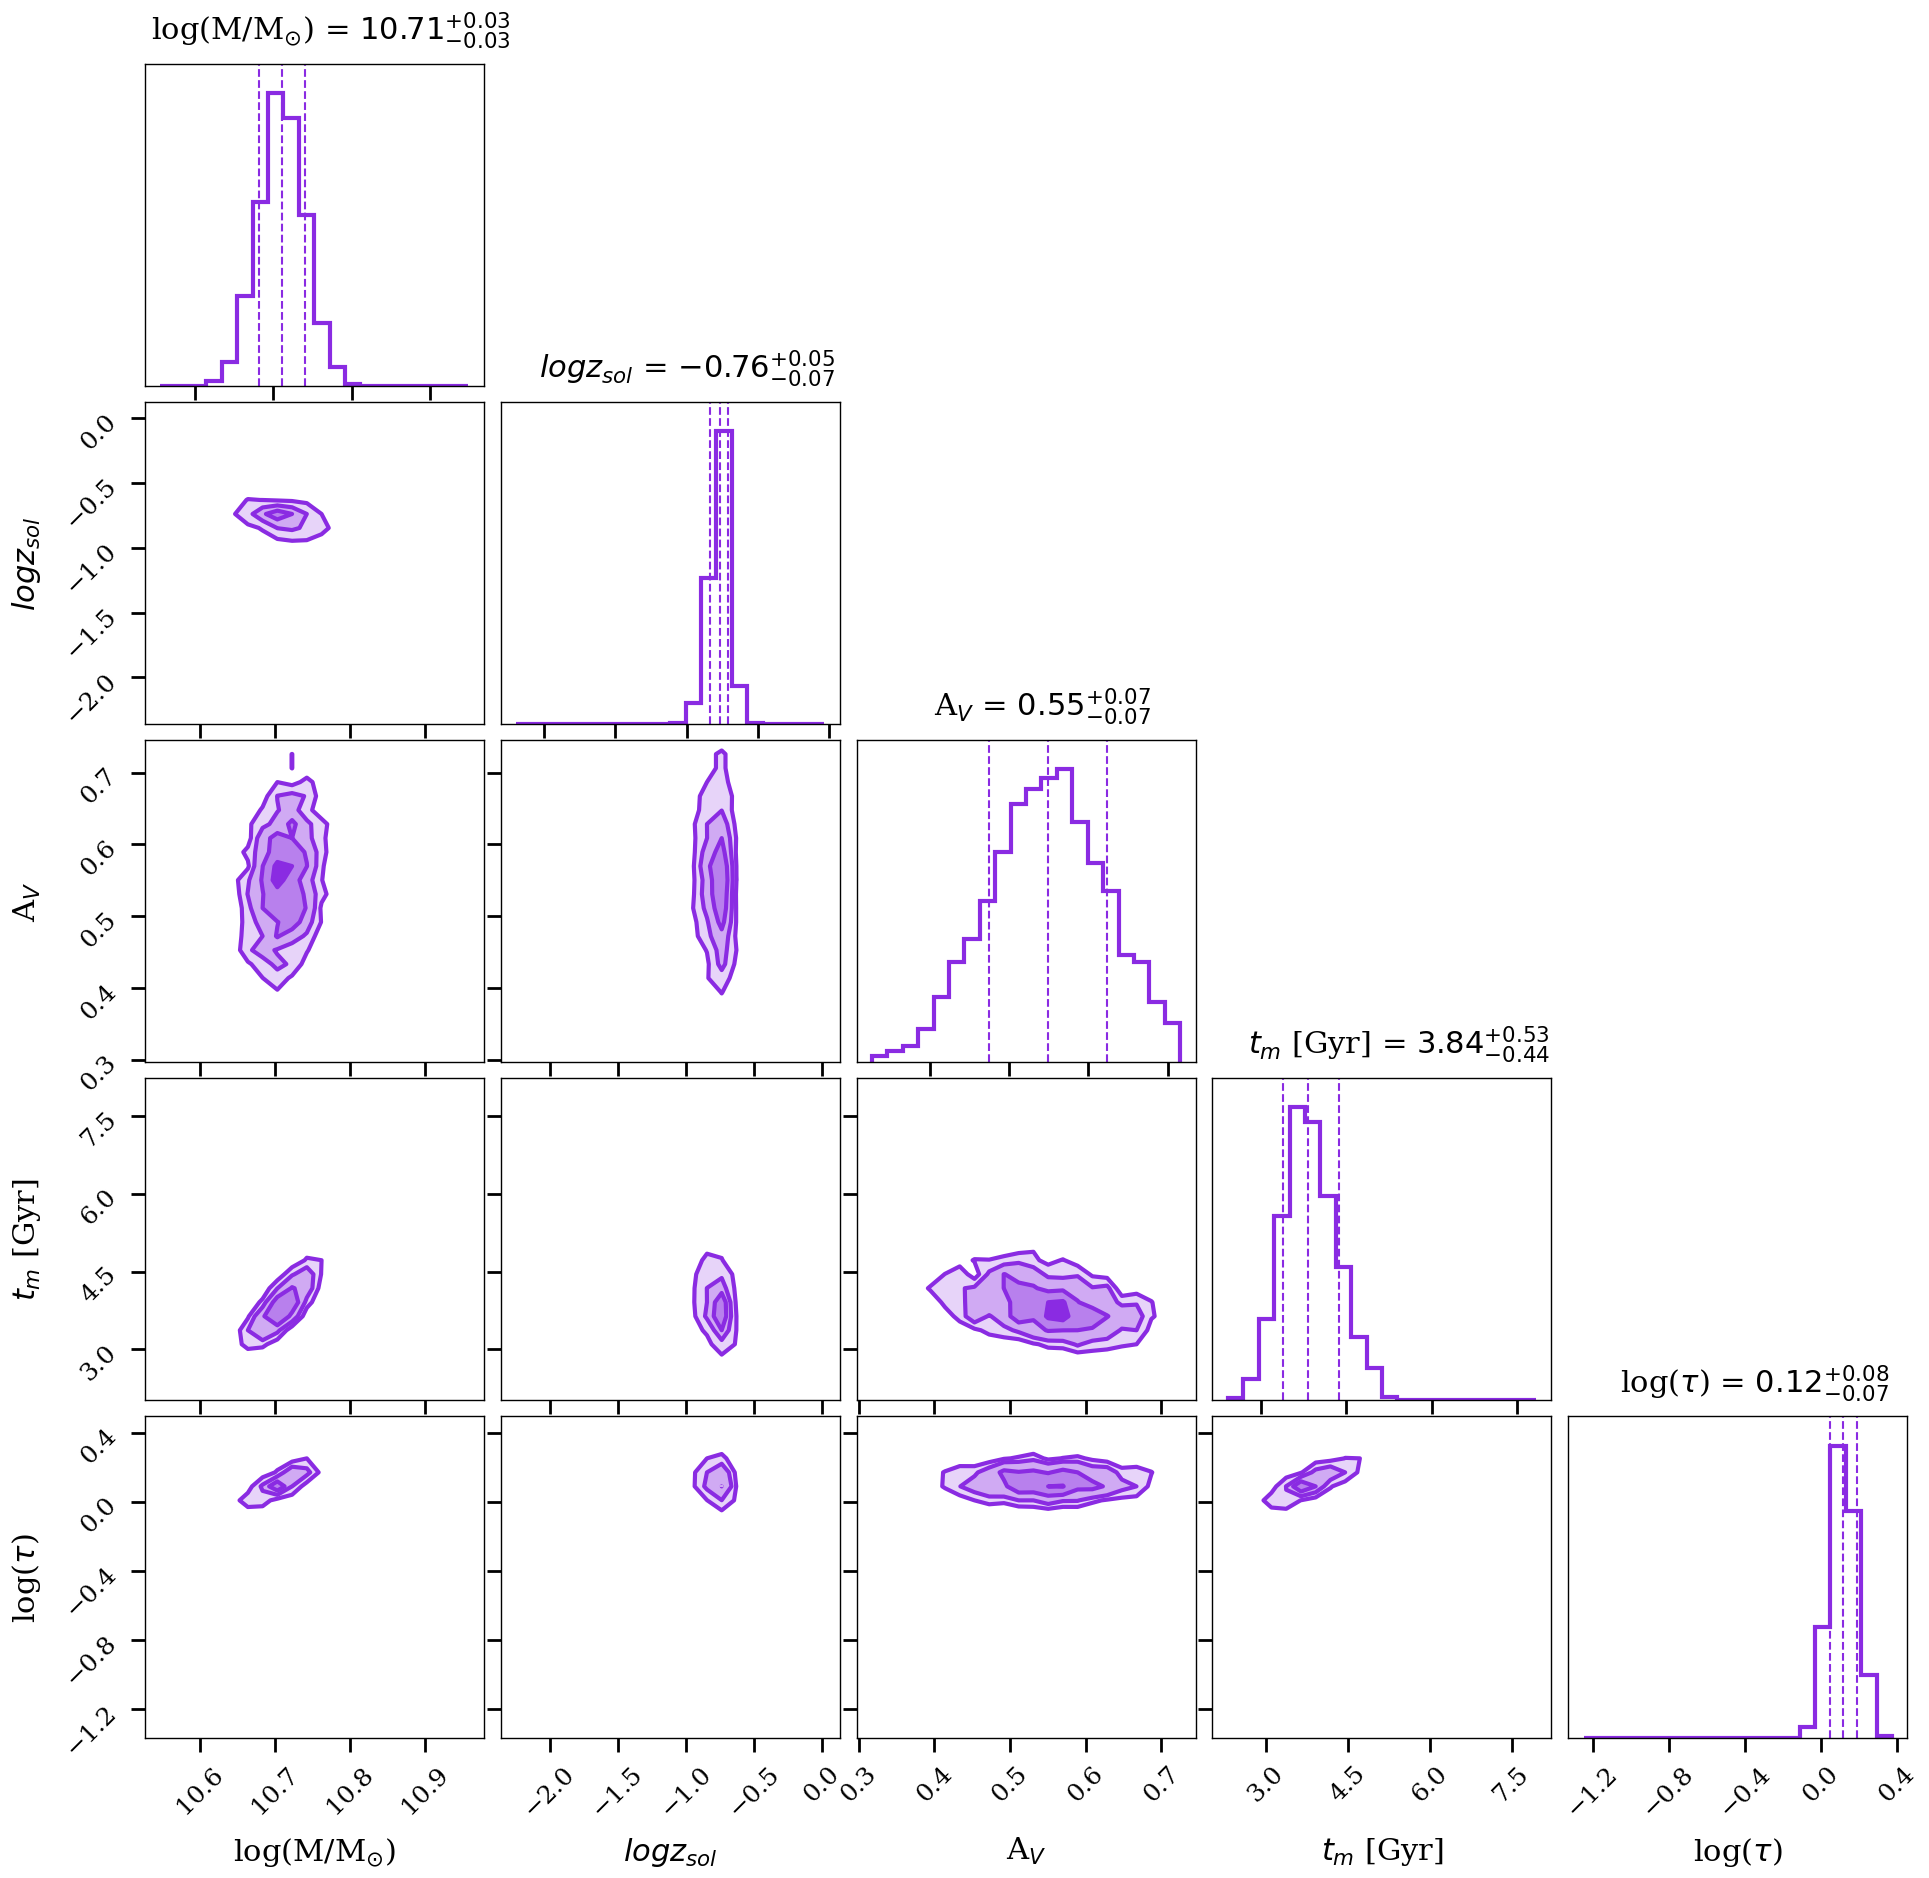

In [471]:

parnames = np.array([r'log(M/M$_{\odot}$)',r'$logz_{sol}$',r'A$_{V}$', r'$t_{m}$ [Gyr]',r'log(${\tau}$)',r'N'], dtype='U20')

# Change title_fmt to ' .3f' if you want 3 decimal places out
cornerfig = anya_subcorner(result, start=700, thin=1, labels=parnames,
                           fig=plt.subplots(5,5,figsize=(20,19))[0], 
                           title_kwargs={"fontsize": 22, 'x': 0.55, 'y':1.05}, 
                           label_kwargs={"fontsize": 22}, 
                           color = 'blueviolet', hist_kwargs = {"alpha": 1, "linewidth":3}, 
                           title_fmt = ' .2f', contour_kwargs={"linewidths":3})

for ax in cornerfig.get_axes():
    ax.tick_params(axis='both', labelsize=18, length=10, width=2)

In [472]:
sps = build_sps(**run_params)
model = build_model(**run_params)

flatchain = result['chain']

from prospect.utils.plotting import quantile
post_pcts = [quantile(flatchain[:, i], percents=50, weights=result.get("weights", None))
             for i in range(model.ndim)]

# These should have all the converged values
print(post_pcts)

mspec_conv, mphot_conv, _ = model.mean_model(post_pcts, obs, sps=sps)
print(mphot_conv)


[51352989297.730675, -0.7642942058061535, 0.5053000779056243, 6.186122596728951, 1.3031684004545656]
[1.29689455e-08 2.52491703e-08 3.38423532e-08 4.03503594e-08
 4.61377713e-08 4.04612119e-09 1.13900414e-08 2.50349302e-08
 3.36304837e-08 4.18485210e-08]


In [62]:
#Calculating stellar mass:
theta = model.theta
specs, mags, sm = model.mean_model(theta, sps=sps, obs=obs)
print(sm)
total_mass = post_pcts[0]
stellar_mass = float(sm)*(np.log10(total_mass))
print(stellar_mass,np.log10(total_mass))


0.6175326633186285
6.754392004462734 10.937708085212115


In [69]:
# Chop the weights to the same amount as the iterations used in generating the SFRs
# This weight will be used to calculate the SFR and Mass formed in each bin
#weights=result.get("weights", None)
#print(len(weights))
#WEIGHTS = []
#for i in range(len(weights)):
#    if i > 0:
#        WEIGHTS.append(weights[i])
#print(len(WEIGHTS))
WEIGHTS =result.get("weights", None)
print(len(WEIGHTS))

2200


Text(0.5, 0, 'Age')

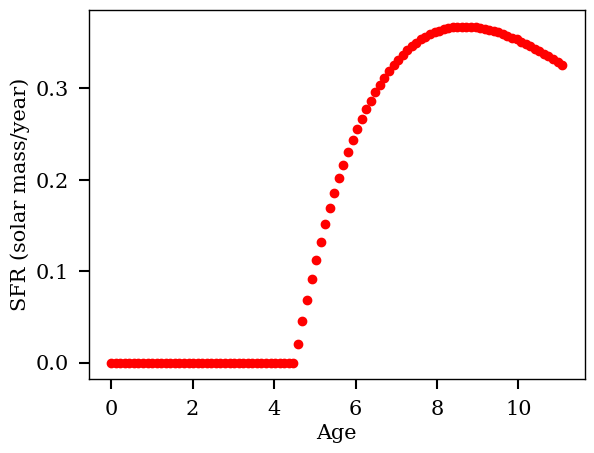

In [97]:
import matplotlib.pyplot as plt
times = np.linspace(0, 11.071, 100) #the age of the universe at z = 0.06
tage = 4.5 #9.58 #4.5
tau = 10**(0.62)
ta = (times-tage)/tau
sfh = ta*np.exp(-ta)
sfh[sfh<0] = 0
plt.plot(times,sfh,'or')
#plt.ylim(0,)
plt.ylabel('SFR (solar mass/year)')
plt.xlabel('Age')